In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
def percentage(df, df1, item):
    """Prints out number of samples and percent of total"""
    """df is the base and df1 is specific df we are interested in and item is the column we are trying to look at"""

    all_loans = df[item].value_counts().sort_index()
    bad_loans = pd.DataFrame(
        df1[item].value_counts().sort_index() / all_loans * 100)
    n_percent = pd.concat([all_loans, bad_loans], axis=1)
    n_percent.columns = ['n_samples', 'percent']
    n_percent.fillna(0, inplace=True)
    print(n_percent)


def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [3]:
def numeric_graph(feature):
    
    """Makes a graph of a numeric column by turn the data into a ECDF"""
    
    feature_interest = df[[feature,'loan_status']].dropna()
    
    #good loans
#    good_x,good_y = ecdf(feature_interest.loc[feature_interest.loan_status == 1][feature])
#    plt.plot(good_x,good_y,marker='.',linestyle='none',color='green',label='Fully Paid')
    
    #population
#    pop_x,pop_y = ecdf(feature_interest[feature])
#    plt.plot(pop_x,pop_y,marker='.',linestyle='none',color='black',label='All loans')
    
    #bad loans
    bad_x,bad_y = ecdf(feature_interest.loc[feature_interest.loan_status == 0][feature])
    plt.plot(bad_x,bad_y,marker='.',linestyle='none',color='red',label='Charged Off')
    
    
    plt.title(feature.upper())
    plt.axis([np.percentile(bad_x,2.5), np.percentile(bad_x,97.5), 0, 1])
    plt.xlabel('Amounts')
    plt.ylabel('% cumulative')
    plt.legend(loc='best')
    
    plt.show()
    
    df_description = pd.concat([#feature_interest[feature].describe(),
                                #feature_interest.loc[feature_interest.loan_status == 1][feature].describe(),                                
                                feature_interest.loc[feature_interest.loan_status == 0][feature].describe()],
                               axis=1)
#    df_description.columns = ['All loans', 'Fully Paid','Charged Off']
    df_description.columns = ['Charged Off']
    print(df_description)

In [4]:
df = pd.read_csv('loan_data_core.csv')
df.info()

C:\Users\leero\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507640 entries, 0 to 2507639
Columns: 151 entries, id to settlement_term
dtypes: float64(112), int64(1), object(38)
memory usage: 2.8+ GB


In [5]:
# conversions
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%y')
df.sec_app_earliest_cr_line = pd.to_datetime(
    df.sec_app_earliest_cr_line, format='%b-%y')
df['sec_length_of_cr'] = df.issue_d - df.sec_app_earliest_cr_line
df.sec_length_of_cr.fillna(0, inplace=True)
df.sec_length_of_cr = df.sec_length_of_cr.dt.days.astype(int)/365
df['length_of_cr'] = df.issue_d - df.earliest_cr_line
df.length_of_cr = df.length_of_cr.dt.days.astype(int)/365

df.int_rate = df.int_rate.apply(
    lambda interest: interest[0:len(interest)-1]).astype('float64')

df.revol_util.fillna('0%', inplace=True)
df.revol_util = df.revol_util.astype('str')
df.revol_util = df.revol_util.apply(
    lambda usage: usage[0:len(usage)-1]).astype('float64')

# good loans = 1
df.loan_status = df.loan_status.apply(
    lambda loan_status: 1 if loan_status != 'Charged Off' else 0)
df.term = df.term.apply(lambda months: int(months[1:3]))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507640 entries, 0 to 2507639
Columns: 153 entries, id to length_of_cr
dtypes: datetime64[ns](3), float64(116), int64(3), object(31)
memory usage: 2.9+ GB


In [6]:
import re

df.emp_length.fillna('0 years', inplace=True)

df.emp_length = df.emp_length.apply(
    lambda len_emp: re.findall(r'\d+', len_emp)[0])

# filled nans as 0,interestingly enough unemployed people had a failure rate of 0

In [7]:
# random things of interest

df['collected'] = df.total_rec_int + df.total_rec_prncp
df['total_debt'] = df.term * df.installment

df['outstanding'] = df.total_debt - df.collected
df['outstanding_percent'] = df.outstanding / df.total_debt

df['princple_outstanding'] = df.loan_amnt - df.collected
df['princple_outstanding_percent'] = df.princple_outstanding/df.loan_amnt

df['effective_int_rate'] = (pow(df.int_rate/1200+1,12)-1) * 100


In [8]:
df_bad = df.loc[df.loan_status == 0]
df_pass = df.loc[df.loan_status == 1]

# the fail rate
print(len(df_bad)/len(df))
print(len(df_bad), len(df_pass))

print('Passing rates')
print('By rows: ', len(df_pass)/len(df))
print('By loan amount: ', np.average(df.loan_status, weights=df.loan_amnt))
print('By interest rate: ', np.average(df.int_rate, weights=df.loan_status))

0.19864095324687756
498120 2009520
Passing rates
By rows:  0.8013590467531224
By loan amount:  0.7862432609493137
By interest rate:  12.642111748079147


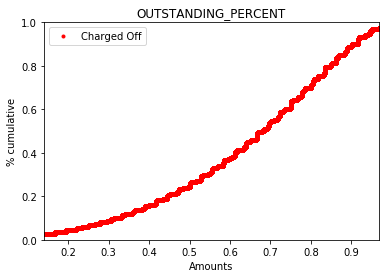

         Charged Off
count  498120.000000
mean        0.643983
std         0.221063
min        -1.410680
25%         0.500216
50%         0.682516
75%         0.817521
max         1.000000


In [9]:
numeric_graph('outstanding_percent')

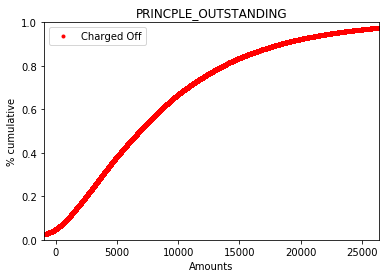

         Charged Off
count  498120.000000
mean     8390.125583
std      7100.089863
min    -24683.800000
25%      3179.382500
50%      6866.645000
75%     12084.865000
max     40000.000000


In [10]:
numeric_graph('princple_outstanding')

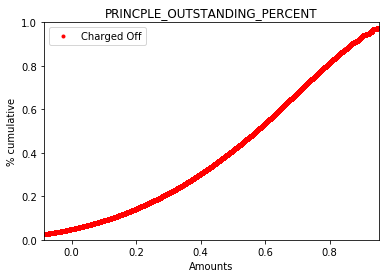

         Charged Off
count  498120.000000
mean        0.530862
std         0.282095
min        -0.721846
25%         0.344073
50%         0.572631
75%         0.753026
max         1.000000


In [11]:
numeric_graph('princple_outstanding_percent')

In [12]:
print(min(df.issue_d),max(df.issue_d))

2007-06-01 00:00:00 2018-12-01 00:00:00
